# Pre - Processing: loading the data sets. 
# the data is within a dictionary by the name - neural_data

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import importlib
import sys
import os
import pickle 
import sklearn
from sklearn.svm import SVC
from sklearn.linear_model import Lasso,LogisticRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(r"C:\Users\denhal.WISMAIN\Weizmann Institute Dropbox\DeanAdam Halperin\BrainValue\Code\neural_pipeline"))
import processing
from processing.preprocessing import DataPreProcessing,feature_selection
from models.classifier import Classifier




In [ ]:
# Load Tamar's data  - NOT RELEVANT FOR EXAMPLE USAGE

tamar_path  = r"C:\Users\denhal.WISMAIN\Weizmann Institute Dropbox\DeanAdam Halperin\BrainValue\Code\databases\Tamar_data.pkl"

# Load the data from the pickle file
with open(tamar_path, 'rb') as file:
    tamar_data = pickle.load(file)

tamar_dates = list(tamar_data.keys())

# iterate over dates within tamar_data
for i,date in enumerate(tamar_dates):
     if i == 8:
        break
neural_data = tamar_data[date]['neural_data']
event_data = tamar_data[date]['event_data']
data_preprocessing = DataPreProcessing(neural_data,event_data)


KeyboardInterrupt: 

In [ ]:
# load D062 data -example usage
D062_spikes = r"D:\Dean\31082025\processed_data\neural_data_spikes.pkl"
D062_hi_res = r"D:\Dean\31082025\processed_data\neural_data_hi-res.pkl"
D062_lfp = r"D:\Dean\31082025\processed_data\neural_data_lfp.pkl"
D062_events = r"D:\Dean\31082025\processed_data\event_data.pkl"
with open(D062_spikes, 'rb') as file:
    neural_data = pickle.load(file)
with open(D062_events, 'rb') as file:
    analog_event_data = pickle.load(file)
with open(D062_hi_res, 'rb') as file:
    sbp_data = pickle.load(file)
with open(D062_lfp, 'rb') as file:
    lfp_data = pickle.load(file)

for electrode in sbp_data:
    if electrode in neural_data:
        neural_data[electrode]['sbp'] = sbp_data[electrode]['hi-res']
    else:
        neural_data[electrode] = {}
        neural_data[electrode]['sbp'] = sbp_data[electrode]['hi-res']
for electrode in lfp_data:
    if electrode in neural_data:
        neural_data[electrode]['lfp'] = lfp_data[electrode]['lfp']
    else:
        neural_data[electrode] = {}
        neural_data[electrode]['lfp'] = lfp_data[electrode]['lfp']

event_data = analog_event_data[1] 
neural_data[269] = {} 

In [3]:

# create events that include block number for easier contrasts:
event_byte = [e['byte'] for e in event_data]
event_ts = [e['time_s'] for e in event_data]
learning_block_start_idx = [i for i in range(len(event_byte)) if event_byte[i] == 5]

which_block = 0
for i,e in enumerate(event_byte):
    
    if (e == 5) or (e == 7):
        which_block += 1
    if e == 22: # gain_tone
        label = 'gain tone'
    elif e == 23:
        label = 'loss tone'
    elif (e==24) or (e==25):
        label = 'shape 1'
    elif (e==26) or (e==27):
        label = 'shape 2'
    elif (e == 30) or (e == 31) or (e == 32):
        label = 'point bar start'
    elif e == 33:
        label = 'point bar gain'
    elif e == 34:
        label = 'point bar loss'
    elif e == 35:
        label = 'point bar nothing'
    else:
        label = 'other'
    label = 'block'+str(which_block)+'_'+label
    event_data[i]['label'] = label



number of features: 150
[108 109 110 117 118 119 150 151 152 210 211 212 213 214 215 291 292 293
 294 295 296 309 310 311 420 421 422 423 424 425]
selected features: [{'electrode': 263, 'stream': 'sbp', 'time': (0, 1500), 'time bin': 1}, {'electrode': 263, 'stream': 'sbp', 'time': (0, 1500), 'time bin': 2}, {'electrode': 263, 'stream': 'sbp', 'time': (0, 1500), 'time bin': 3}, {'electrode': 267, 'stream': 'sbp', 'time': (0, 1500), 'time bin': 1}, {'electrode': 267, 'stream': 'sbp', 'time': (0, 1500), 'time bin': 2}, {'electrode': 267, 'stream': 'sbp', 'time': (0, 1500), 'time bin': 3}, {'electrode': 7, 'stream': 'sbp', 'time': (0, 1500), 'time bin': 1}, {'electrode': 7, 'stream': 'sbp', 'time': (0, 1500), 'time bin': 2}, {'electrode': 7, 'stream': 'sbp', 'time': (0, 1500), 'time bin': 3}, {'electrode': 27, 'stream': 'sbp', 'time': (0, 1500), 'time bin': 1}, {'electrode': 27, 'stream': 'sbp', 'time': (0, 1500), 'time bin': 2}, {'electrode': 27, 'stream': 'sbp', 'time': (0, 1500), 'time 

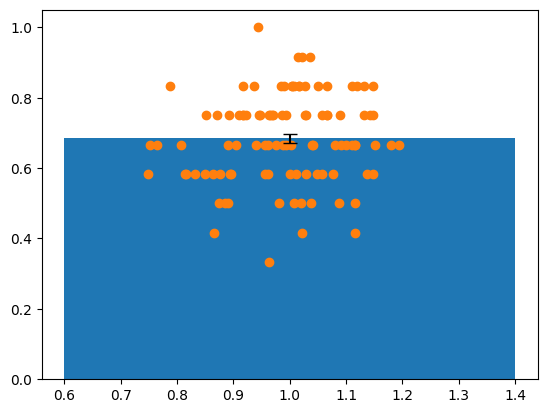

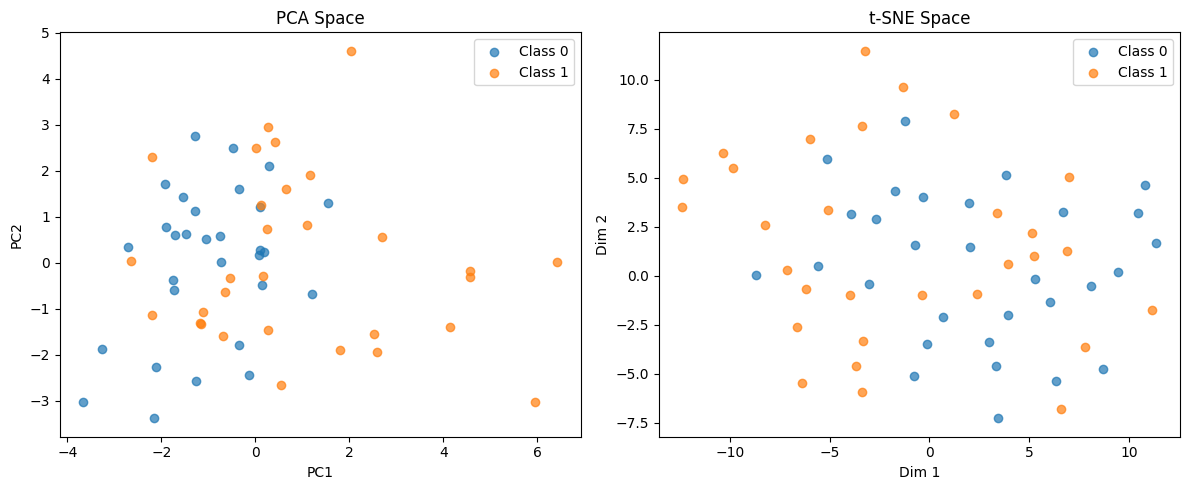

In [ ]:
# ------------------------------------------------------------
# Imports
# ------------------------------------------------------------
from scipy.stats import mode
from models.classifier import run_nested_cv
from Classification_pipeline import run_pipeline, draw_reduced_dim
importlib.reload(processing)


# ------------------------------------------------------------
# Configuration Parameters
# ------------------------------------------------------------

# Trials to include (start, end) — None = until the end
# Example: trials_to_use = (1, 36)
trials_to_use = (0, None)

# Size of each bin in milliseconds
bin_size = 500

# Normalization method: options = None / 'local baseline' / 'response zscore' / 'global baseline'
norm_method = 'local baseline'

# Feature selection method: options = 'correlation' / 'lasso' / 'pca'
feature_selection_method = 'correlation'

# Maximum number of features to select
max_num_features = 10

# Time window (in ms) around the event for locking data
time_before_event = 1000
time_after_event = 3000

# Time range (in ms) to use for classification (relative to event onset)
time_to_use = (0, 1500)

# Classifier type 
classifier_name = 'svm'

# Output data dimension:
#   3 = (sample, feature, time) - every feature*time will then become a new feature, to keep 2d
#   2 = (sample, feature averaged over time)
output_dim = 3

# Neural data streams to use (e.g., spikes, sbp, lfp)
streams_to_use = ['sbp', 'lfp']

# Whether to expand features (e.g., add LFP band power and PCA on spikes)
expand_features = False

# Whether to keep all features from the same electrode when one is selected
keep_entire_electrode = True


# ------------------------------------------------------------
# Run Neural Data Pipeline
# ------------------------------------------------------------
# The pipeline:
#   1. Prepares neural data (locking, filtering, feature extraction)
#   2. Runs classification on 100 iterations of random train/test splits

classifiers, accuracies, results_dict, X, y, sorted_indices, feature_dict_list = run_pipeline(
    neural_data,
    event_data,
    ['block1_gain tone', 'block1_loss tone'],  # Event labels to lock to
    ['gain tone', 'loss tone'],                # Event names to assign
    trials_to_use=trials_to_use,
    bin_size=bin_size,
    norm_method=norm_method,
    feature_selection_method=feature_selection_method,
    time_to_use=time_to_use,
    max_num_features=max_num_features,
    output_dim=output_dim,
    time_before_event=time_before_event,
    time_after_event=time_after_event,
    classifier_name=classifier_name,
    streams_to_use=streams_to_use,
    expand_features=expand_features,
    keep_entire_electrode=keep_entire_electrode
)

# Display selected features
print("selected features:", [feature_dict_list[i] for i in sorted_indices])


# ------------------------------------------------------------
# Visualization: Classification Accuracy
# ------------------------------------------------------------
accuracies = np.array(accuracies)

# Plot mean classification accuracy
plt.bar(1, np.mean(accuracies))

# Add individual iteration accuracies with jitter
jitter_x = np.random.normal(size=(1, accuracies.shape[0]), scale=0.1, loc=0)
plt.scatter(1 + jitter_x, accuracies)

# Add error bar (SEM)
plt.errorbar(
    1,
    np.mean(accuracies),
    yerr=np.std(accuracies) / np.sqrt(accuracies.shape[0]),
    fmt='none',
    capsize=5,
    color='black'
)


# ------------------------------------------------------------
# Visualization: Reduced Dimensionality Plot
# ------------------------------------------------------------
draw_reduced_dim(X[:, sorted_indices], y)


Nested CV balanced accuracy: mean=0.733 ± 0.062
Best parameters: {'clf__C': np.float64(10.0), 'clf__gamma': np.float64(0.01)}


c:\Users\denhal.WISMAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:646: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\denhal.WISMAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:646: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\denhal.WISMAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:646: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\denhal.WISMAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:646: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\denhal.WISMAIN\AppData\Local\Programs\Python\Python312\Lib\site-pac

number of features: 150


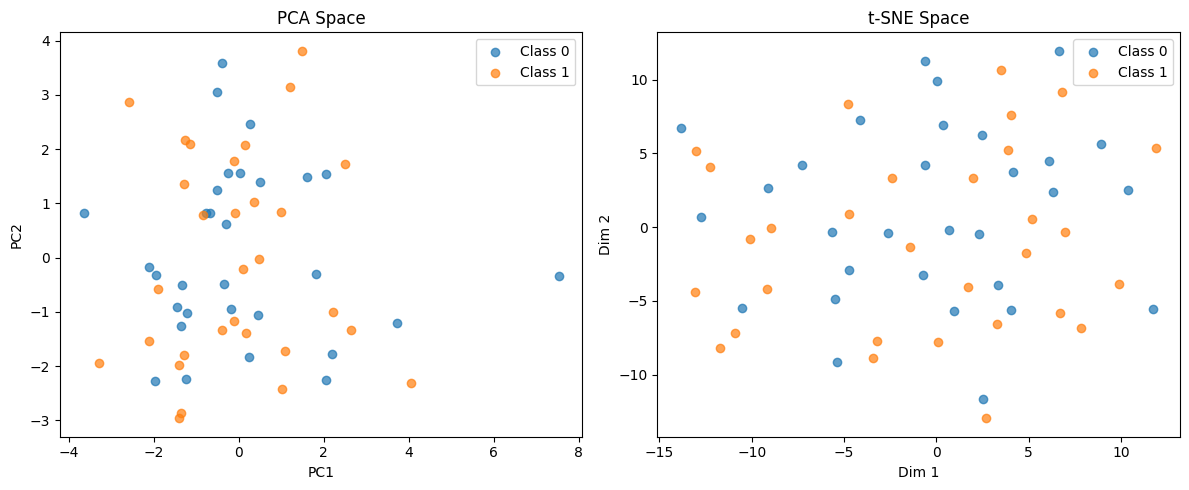

accuracy in final model on selected features 0.0


In [ ]:
# ------------------------------------------------------------
# Nested Cross-Validation and Final Model Prediction
# ------------------------------------------------------------

# Encode labels as integers for classification
y_binary = LabelEncoder().fit_transform(y)


# ------------------------------------------------------------
# Run nested CV classification to optimize classifier
# Returns the final trained model
# ------------------------------------------------------------
final_model = run_nested_cv(
    X[:, sorted_indices],  # Use selected features only
    y_binary,
    classifier_type='svm'
)


# ------------------------------------------------------------
# "Only Test" Mode: Extract X and y of selected features from new data
# ------------------------------------------------------------
only_test = True

X, y = run_pipeline(
    neural_data,
    event_data,
    ['block2_gain tone', 'block2_loss tone'],  # Event labels
    ['gain tone', 'loss tone'],                # Event names
    trials_to_use=trials_to_use,
    bin_size=bin_size,
    norm_method=norm_method,
    feature_selection_method=feature_selection_method,
    time_to_use=time_to_use,
    max_num_features=max_num_features,
    output_dim=output_dim,
    classifier_name=classifier_name,
    streams_to_use=streams_to_use,
    expand_features=expand_features,
    only_test=only_test,
    selected_features=sorted_indices
)


# ------------------------------------------------------------
# Visualization: Reduced Dimensionality of New Data
# ------------------------------------------------------------
draw_reduced_dim(X[:, sorted_indices], y)


# ------------------------------------------------------------
# Evaluate Final Model on Selected Features
# ------------------------------------------------------------
y_pred = final_model.predict(X[:, sorted_indices])
accuracy = np.sum(y_pred == y) / len(y)
print("accuracy in final model on selected features", accuracy)
